In [2]:
import pandas as pd

In [4]:
def split_owner(owner_str):
    """
    Given an owner string like:
    - "Örsted [10%]; Felvig [90%]"  OR
    - "Owner1; Owner2" 
    returns a list of tuples (owner_name, fraction).
    
    If no percentages are provided for multiple owners, each is assigned an equal share.
    If some owners lack percentages while others have them, the remaining percentage is equally
    distributed among those missing percentages.
    """
    if not isinstance(owner_str, str):
        return [("Unknown", 1.0)]


    # Split the string by semicolon to handle multiple owners
    parts = [part.strip() for part in owner_str.split(';')]
    
    # Check if any part contains a percentage
    has_percentage = any('[' in part and ']' in part for part in parts)
    
    result = []
    
    if not has_percentage:
        # No percentages provided: assign equal share to each owner.
        equal_share = 1.0 / len(parts)
        for part in parts:
            # Clean the owner name in case any extraneous text exists
            name = part.split('[')[0].strip()
            result.append((name, equal_share))
    else:
        # Process each part: extract percentage if available.
        for part in parts:
            if '[' in part and ']' in part:
                name = part.split('[')[0].strip()
                percentage_str = part.split('[')[1].split(']')[0].strip().replace('%', '')
                try:
                    percentage = float(percentage_str) / 100.0
                except ValueError:
                    percentage = None
                result.append((name, percentage))
            else:
                # Part without a percentage: mark fraction as None for now.
                result.append((part, None))
        
        # For parts that are missing percentages, assign an equal share of the remaining capacity.
        total_assigned = sum(p for _, p in result if p is not None)
        missing_count = sum(1 for _, p in result if p is None)
        if missing_count > 0:
            remaining = max(0, 1.0 - total_assigned)  # Avoid negative
            missing_share = remaining / missing_count
            result = [(name, p if p is not None else missing_share) for name, p in result]
    
    return result

# Assume merged_bio is your DataFrame containing the "Owner" and "Capacity (MW)" columns.
# For example, if reading from CSV:
# merged_bio = pd.read_csv("Bioenergy_merged.csv")

# Create a new list to store expanded rows



In [19]:
df_over = pd.read_csv("Data/Bioenergy_overthresh.csv")
df_under = pd.read_csv("Data/Bioenergy_underthresh.csv")

# Concatenate the DataFrames vertically (row-wise)
Bio_df = pd.concat([df_over, df_under], ignore_index=True)
Active_bio_df = Bio_df[Bio_df['Status'] == 'operating']
Active_bio_df.rename(columns={'Owner(s)': 'Owner'}, inplace=True)


expanded_rows = []

for idx, row in Active_bio_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Optionally, group by owner to get total attributed capacity per company
Bio_capacity_by_company = expanded_df.groupby("Owner")["Attributed Capacity (MW)"].sum().reset_index()

# Display the result
sum(Bio_capacity_by_company['Attributed Capacity (MW)'])

/var/folders/7j/s2kkprgj0zx6hrn11xc4tlwc0000gp/T/ipykernel_46088/2460331991.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_bio_df.rename(columns={'Owner(s)': 'Owner'}, inplace=True)


84316.87

In [86]:
Bio_capacity_by_company['']

,Owner(s),Attributed Capacity (MW)
0,A2A SpA,252.00
1,AEB Exploitatie BV,111.00
2,ALLETE Inc,73.00
3,AVA GmbH,76.00
4,AWEP Onahama,75.00
...,...,...
901,other,1689.16
902,swb AG,50.00
903,Öresundskraft AB,70.00
904,Övik Energi AB,40.00


In [6]:
Coal_df = pd.read_csv("Data/Coal.csv")
Active_Coal_df = Coal_df[Coal_df['Status'] == 'operating']


expanded_rows = []

for idx, row in Active_Coal_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Parent"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Optionally, group by owner to get total attributed capacity per company
Coal_capacity_by_company = expanded_df.groupby("Owner")["Attributed Capacity (MW)"].sum().reset_index()

# Display the result
sum(Coal_capacity_by_company['Attributed Capacity (MW)'])



2140264.5022000023

In [254]:
Coal_capacity_by_company.sort_values(by = "Attributed Capacity (MW)", ascending=False).iloc[]


,Owner,Attributed Capacity (MW)
705,Huaneng Power International Inc,75511.770
237,China Energy Investment Corp,60115.940
1048,NTPC Ltd,59395.000
273,China Shenhua Energy Co Ltd,49675.635
441,Eskom Holdings SOC Ltd,43731.800
...,...,...
1612,Talen Energy Corp,4686.600
888,Karnataka Power Corp Ltd,4666.400
712,Hubei Energy Group Co Ltd,4586.000
374,Dominion Energy Inc,4576.200


In [16]:
df_over = pd.read_csv("Data/Geothermal_overthresh.csv")
df_under = pd.read_csv("Data/Geothermal_underthres.csv")

# Concatenate the DataFrames vertically (row-wise)
Geo_df = pd.concat([df_over, df_under], ignore_index=True)

Active_Geo_df = Geo_df[Geo_df['Status'] == 'operating']


expanded_rows = []

for idx, row in Active_Geo_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Optionally, group by owner to get total attributed capacity per company
Geo_capacity_by_company = expanded_df.groupby("Owner")["Attributed Capacity (MW)"].sum().reset_index()

# Display the result
sum(Geo_capacity_by_company['Attributed Capacity (MW)'])

13908.74

In [17]:
df_over = pd.read_csv("Data/Hydro_overthresh.csv")
df_under = pd.read_csv("Data/Hydro_underhresh.csv")

# Concatenate the DataFrames vertically (row-wise)
Hydro_df = pd.concat([df_over, df_under], ignore_index=True)

Active_Hydro_df = Hydro_df[Hydro_df['Status'] == 'operating']


expanded_rows = []

for idx, row in Active_Hydro_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Optionally, group by owner to get total attributed capacity per company
Hydro_capacity_by_company = expanded_df.groupby("Owner")["Attributed Capacity (MW)"].sum().reset_index()

# Display the result
sum(Hydro_capacity_by_company['Attributed Capacity (MW)'])


1136616.6191400008

In [314]:
Hydro_capacity_by_company.sort_values('Attributed Capacity (MW)')

,Owner,Attributed Capacity (MW)
546,Madulain,0.0150
850,Sunnfjord Municipality,0.1064
983,Zuoz,0.1800
198,DDC and 18 VDCs of Rasuwa District,0.1920
576,Municipality of Chalais,0.4450
...,...,...
838,State Grid Xinyuan CO LTD,23692.0000
633,PJSC RusHydro,27749.0000
441,Hydro Québec,35999.0000
907,Unknown,39586.0727


In [9]:
Nuclear_df = pd.read_csv("Data/Nuclear.csv")

# Filter rows where 'Status' is 'operating'
Active_Nuclear_df = Nuclear_df[Nuclear_df['Status'] == 'operating']

# Convert the " Capacity (MW) " column to numeric, without replacing the whole DataFrame
Active_Nuclear_df.loc[:, " Capacity (MW) "] = pd.to_numeric(Active_Nuclear_df[" Capacity (MW) "], errors="coerce")


expanded_rows = []

# Process each row to attribute capacity based on the split_owner function
for idx, row in Active_Nuclear_df.iterrows():
    capacity = row[" Capacity (MW) "]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Group by owner to get total attributed capacity per company
Nuclear_capacity_by_company = expanded_df.groupby("Owner")["Attributed Capacity (MW)"].sum().reset_index()

# Display the result: sum of attributed capacity across all companies
total_capacity = sum(Nuclear_capacity_by_company['Attributed Capacity (MW)'])
print("Total Attributed Capacity (MW):", total_capacity)

Total Attributed Capacity (MW): 396484.0


In [297]:
Nuclear_capacity_by_company.sort_values('Attributed Capacity (MW)')

,Owner,Attributed Capacity (MW)
95,Unknown,5.0
48,Institute of Nuclear and New Energy Technology,10.0
10,China National Nuclear CORP,25.0
9,China Huaneng Group,211.0
43,Hidroeléctrica del Cantábrico,266.5
...,...,...
32,Exelon,16393.0
11,China National Nuclear Power CO LTD,22350.0
54,Korea Hydro & Nuclear Power CO,27071.0
82,Rosatom,28576.0


In [10]:
df_over = pd.read_csv("Data/Wind_overthresh.csv")
df_under = pd.read_csv("Data/Wind_underthresh.csv")

# Concatenate the DataFrames vertically (row-wise)
Wind_df = pd.concat([df_over, df_under], ignore_index=True)


Active_Wind_df = Wind_df[Wind_df['Status'] == 'operating']


expanded_rows = []

for idx, row in Active_Wind_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Optionally, group by owner to get total attributed capacity per company
Wind_capacity_by_company = expanded_df.groupby("Owner")["Attributed Capacity (MW)"].sum().reset_index()

# Display the result
sum(Wind_capacity_by_company['Attributed Capacity (MW)'])

1005066.9999999999

In [166]:
Areas_coal = set(Coal_df.loc[:,'Subregion'])
Areas_Wind = set(Wind_df.loc[:,'Subregion'])
print(Areas_coal)
print(Areas_Wind)

{'Northern America', 'Northern Europe', 'Central Asia', 'Melanesia', 'Eastern Europe', 'Southern Asia', 'Sub-Saharan Africa', 'South-eastern Asia', 'Latin America and the Caribbean', 'Australia and New Zealand', 'Western Asia', 'Eastern Asia', 'Northern Africa', 'Western Europe', 'Southern Europe'}
{'Northern America', 'Northern Europe', 'Central Asia', 'Melanesia', 'Eastern Europe', 'Southern Asia', 'Sub-Saharan Africa', 'Polynesia', 'Latin America and the Caribbean', 'South-eastern Asia', 'Western Asia', 'Australia and New Zealand', 'Eastern Asia', 'Northern Africa', 'Western Europe', 'Southern Europe'}


In [11]:
df_over = pd.read_csv("Data/Oil_Gas_overthresh.csv")
df_under = pd.read_csv("Data/Oil_Gas_underthresh.csv")

# Concatenate the DataFrames vertically (row-wise)
OilGas_df = pd.concat([df_over, df_under], ignore_index=True)

Active_OilGas_df = OilGas_df[OilGas_df['Status'] == 'operating']
Active_OilGas_df.rename(columns={'Owner(s)': 'Owner'}, inplace=True)


expanded_rows = []

for idx, row in Active_OilGas_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Optionally, group by owner to get total attributed capacity per company
OilGas_capacity_by_company = expanded_df.groupby("Owner")["Attributed Capacity (MW)"].sum().reset_index()

# Display the result
sum(OilGas_capacity_by_company['Attributed Capacity (MW)'])

/var/folders/7j/s2kkprgj0zx6hrn11xc4tlwc0000gp/T/ipykernel_46088/366185136.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Active_OilGas_df.rename(columns={'Owner(s)': 'Owner'}, inplace=True)


2162682.08

In [12]:
df_over = pd.read_csv("Solar_overthresh.csv")
df_under = pd.read_csv("Solar_underthresh.csv")

# Concatenate the DataFrames vertically (row-wise)
Solar_df = pd.concat([df_over, df_under], ignore_index=True)

Active_Solar_df = Solar_df[Solar_df['Status'] == 'operating']


expanded_rows = []

for idx, row in Active_Solar_df.iterrows():
    capacity = row["Capacity (MW)"]
    owner_str = row["Owner"]
    owners = split_owner(owner_str)
    for name, fraction in owners:
        new_row = row.copy()
        new_row["Owner"] = name  # Set the individual owner name
        # Calculate the attributed capacity. If fraction is None for some reason, use full capacity.
        new_row["Attributed Capacity (MW)"] = capacity * fraction if fraction is not None else capacity
        expanded_rows.append(new_row)

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Optionally, group by owner to get total attributed capacity per company
Solar_capacity_by_company = expanded_df.groupby("Owner")["Attributed Capacity (MW)"].sum().reset_index()

# Display the result
sum(Solar_capacity_by_company['Attributed Capacity (MW)'])

991110.0

In [265]:
Solar_capacity_by_company.sort_values('Attributed Capacity (MW)')

,Owner,Attributed Capacity (MW)
3553,Safe Haven Partners LLC,0.266667
3213,Photo File Inc,0.266667
3388,RDI Electronics,0.266667
3007,New York Sports Management,0.266667
1060,DP 21 LLC,0.266667
...,...,...
904,China Three Gorges Renewables (Group) Co Ltd,6039.666667
64,Adani Group,7388.000000
4406,Tianjin China Green Power Investment Co Ltd,11000.000000
3014,NextEra Energy Inc,11107.200000


In [21]:


dfs = [
    Solar_capacity_by_company,
    Wind_capacity_by_company,
    Nuclear_capacity_by_company,
    Coal_capacity_by_company,
    Hydro_capacity_by_company,
    OilGas_capacity_by_company,
    Bio_capacity_by_company,
    Geo_capacity_by_company
]
# 2. Build a master list of unique owners across all DataFrames
dataframes = [
    Solar_capacity_by_company,
    Wind_capacity_by_company,
    Nuclear_capacity_by_company,
    Coal_capacity_by_company,
    Hydro_capacity_by_company,
    OilGas_capacity_by_company,
    Bio_capacity_by_company,
    Geo_capacity_by_company
]



# 1. Rename each DataFrame’s capacity column to a unique name
Solar_capacity_by_company = Solar_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Solar_capacity'}
)
Wind_capacity_by_company = Wind_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Wind_capacity'}
)
Nuclear_capacity_by_company = Nuclear_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Nuclear_capacity'}
)
Coal_capacity_by_company = Coal_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Coal_capacity'}
)
Hydro_capacity_by_company = Hydro_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Hydro_capacity'}
)
OilGas_capacity_by_company = OilGas_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'OilGas_capacity'}
)
Bio_capacity_by_company = Bio_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Bio_capacity'}
)
Geo_capacity_by_company = Geo_capacity_by_company.rename(
    columns={'Attributed Capacity (MW)': 'Geo_capacity'}
)

df_merged = Solar_capacity_by_company.merge(Wind_capacity_by_company, on='Owner', how='outer') \
               .merge(Nuclear_capacity_by_company, on='Owner', how='outer') \
               .merge(Coal_capacity_by_company, on='Owner', how='outer') \
               .merge(Hydro_capacity_by_company, on='Owner', how='outer') \
               .merge(OilGas_capacity_by_company, on='Owner', how='outer') \
               .merge(Bio_capacity_by_company, on='Owner', how='outer') \
               .merge(Geo_capacity_by_company, on='Owner', how='outer')

capacity_cols = [col for col in df_merged.columns if 'capacity' in col]
df_merged['total_capacity'] = df_merged[capacity_cols].sum(axis=1)

# 3. Sort by this new total_capacity column in descending order
df_merged_sorted = df_merged.sort_values(by='total_capacity', ascending=False)

# 4. Select the top 20 rows
df_merged_sorted[:30]

,Owner,Solar_capacity,Wind_capacity,Nuclear_capacity,Coal_capacity,Hydro_capacity,OilGas_capacity,Bio_capacity,Geo_capacity,total_capacity
12923,Unknown,253479.200000,233793.200000,5.0,500.000000,39586.0727,4194.600,11598.0,537.0,543693.072700
6002,Huaneng Power International Inc,3570.000000,1298.000000,NaN,75511.770000,NaN,NaN,60.0,NaN,80439.770000
3574,Electricité de France SA,NaN,NaN,64040.0,1260.000000,NaN,5477.700,NaN,NaN,70777.700000
8386,NTPC Ltd,3782.000000,50.000000,NaN,59395.000000,NaN,4007.000,NaN,NaN,67234.000000
10447,Saudi Electricity Co,53.333333,NaN,NaN,NaN,NaN,60986.500,NaN,NaN,61039.833333
2066,China Energy Investment Corp,NaN,NaN,NaN,60115.940000,NaN,NaN,NaN,NaN,60115.940000
2365,China Shenhua Energy Co Ltd,225.000000,NaN,NaN,49675.635000,NaN,NaN,NaN,NaN,49900.635000
6672,JERA Co Inc,NaN,331.033333,NaN,NaN,NaN,47098.200,NaN,NaN,47429.233333
3992,Eskom Holdings SOC Ltd,NaN,100.000000,NaN,43731.800000,NaN,2418.000,NaN,NaN,46249.800000
3013,Datang International Power Generation Co Ltd,1914.566667,1486.500000,NaN,38631.140000,NaN,1500.000,NaN,NaN,43532.206667


In [22]:
import pandas as pd

data = [
    {
        "Region": "Australia & New Zealand",
        "Nuclear": None,
        "Coal": 50,
        "Hydro": 35,
        "Gas & Oil": 45,
        "Wind": 35,
        "Solar": 20,
        "Bioenergy": 60,
        "Geothermal": 80
    },
    {
        "Region": "Central Asia",
        "Nuclear": None,
        "Coal": 50,
        "Hydro": 40,
        "Gas & Oil": 55,
        "Wind": 25,
        "Solar": 18,
        "Bioenergy": 40,
        "Geothermal": None
    },
    {
        "Region": "Eastern Asia",
        "Nuclear": 82,
        "Coal": 55,
        "Hydro": 40,
        "Gas & Oil": 43,  # Midpoint of ~40–45%
        "Wind": 25,
        "Solar": 18,
        "Bioenergy": 65,
        "Geothermal": 70
    },
    {
        "Region": "Eastern Europe",
        "Nuclear": 75,
        "Coal": 50,
        "Hydro": 35,
        "Gas & Oil": 40,
        "Wind": 30,
        "Solar": 15,
        "Bioenergy": 60,
        "Geothermal": 70
    },
    {
        "Region": "Latin America & the Caribbean",
        "Nuclear": 80,
        "Coal": 55,
        "Hydro": 53,  # Midpoint of ~50–55%
        "Gas & Oil": 50,
        "Wind": 35,
        "Solar": 20,
        "Bioenergy": 65,
        "Geothermal": 70
    },
    {
        "Region": "Melanesia",
        "Nuclear": None,
        "Coal": None,
        "Hydro": 25,
        "Gas & Oil": 40,
        "Wind": 20,
        "Solar": 18,
        "Bioenergy": 40,
        "Geothermal": 60
    },
    {
        "Region": "Northern Africa",
        "Nuclear": None,
        "Coal": 40,
        "Hydro": 30,
        "Gas & Oil": 45,
        "Wind": 30,
        "Solar": 25,
        "Bioenergy": 50,
        "Geothermal": None
    },
    {
        "Region": "Northern America",
        "Nuclear": 90,
        "Coal": 45,
        "Hydro": 40,
        "Gas & Oil": 55,
        "Wind": 40,
        "Solar": 22,
        "Bioenergy": 65,
        "Geothermal": 70
    },
    {
        "Region": "Northern Europe",
        "Nuclear": 85,
        "Coal": 30,
        "Hydro": 45,
        "Gas & Oil": 30,
        "Wind": 35,
        "Solar": 10,
        "Bioenergy": 70,
        "Geothermal": 80
    },
    {
        "Region": "South-eastern Asia",
        "Nuclear": None,
        "Coal": 55,
        "Hydro": 45,
        "Gas & Oil": 50,
        "Wind": 25,
        "Solar": 15,
        "Bioenergy": 60,
        "Geothermal": 70
    },
    {
        "Region": "Southern Asia",
        "Nuclear": 80,
        "Coal": 55,
        "Hydro": 40,
        "Gas & Oil": 50,
        "Wind": 25,
        "Solar": 18,
        "Bioenergy": 60,
        "Geothermal": None
    },
    {
        "Region": "Southern Europe",
        "Nuclear": 70,
        "Coal": 35,
        "Hydro": 35,
        "Gas & Oil": 40,
        "Wind": 30,
        "Solar": 18,
        "Bioenergy": 60,
        "Geothermal": 70
    },
    {
        "Region": "Sub-Saharan Africa",
        "Nuclear": 75,
        "Coal": 55,
        "Hydro": 28,  # Midpoint of ~25–30%
        "Gas & Oil": 40,
        "Wind": 30,
        "Solar": 20,
        "Bioenergy": 60,
        "Geothermal": 70
    },
    {
        "Region": "Western Asia",
        "Nuclear": 80,
        "Coal": 40,
        "Hydro": 30,
        "Gas & Oil": 60,
        "Wind": 25,
        "Solar": 25,
        "Bioenergy": 40,
        "Geothermal": 70
    },
    {
        "Region": "Western Europe",
        "Nuclear": 75,
        "Coal": 30,
        "Hydro": 35,
        "Gas & Oil": 35,
        "Wind": 30,
        "Solar": 12,
        "Bioenergy": 65,
        "Geothermal": 70
    }
]

df = pd.DataFrame(data)
print(df)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(data)

# Drop the 'Region' column to focus on numeric columns
df_numeric = df.drop(columns=["Region"])

# Compute the mean of each column, ignoring None/NaN
means = df_numeric.mean(numeric_only=True)

# Convert to a dictionary (or you can keep it as a Series)
averages_dict = means.to_dict()

averages_dict

capacity_factors = {
    "Solar_capacity": 0.18,
    "Wind_capacity": 0.29,
    "Nuclear_capacity": 0.79,
    "Coal_capacity": 0.46,
    "Hydro_capacity": 0.42,
    "OilGas_capacity": 0.45,
    "Bio_capacity": 0.57,
    "Geo_capacity": 0.70
}

for col, factor in capacity_factors.items():
    gen_col = col.replace("_capacity", "_generation")
    df_merged_sorted[gen_col] = df_merged_sorted[col] * factor * 8760 /1000000 #TWh



                           Region  Nuclear  Coal  Hydro  Gas & Oil  Wind  \
0         Australia & New Zealand      NaN  50.0     35         45    35   
1                    Central Asia      NaN  50.0     40         55    25   
2                    Eastern Asia     82.0  55.0     40         43    25   
3                  Eastern Europe     75.0  50.0     35         40    30   
4   Latin America & the Caribbean     80.0  55.0     53         50    35   
5                       Melanesia      NaN   NaN     25         40    20   
6                 Northern Africa      NaN  40.0     30         45    30   
7                Northern America     90.0  45.0     40         55    40   
8                 Northern Europe     85.0  30.0     45         30    35   
9              South-eastern Asia      NaN  55.0     45         50    25   
10                  Southern Asia     80.0  55.0     40         50    25   
11                Southern Europe     70.0  35.0     35         40    30   
12          

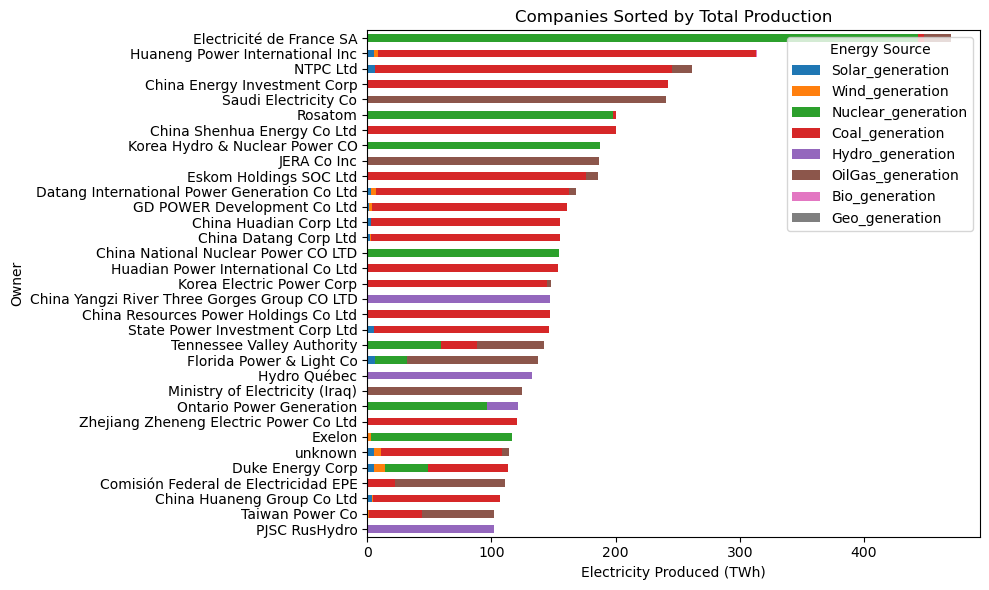

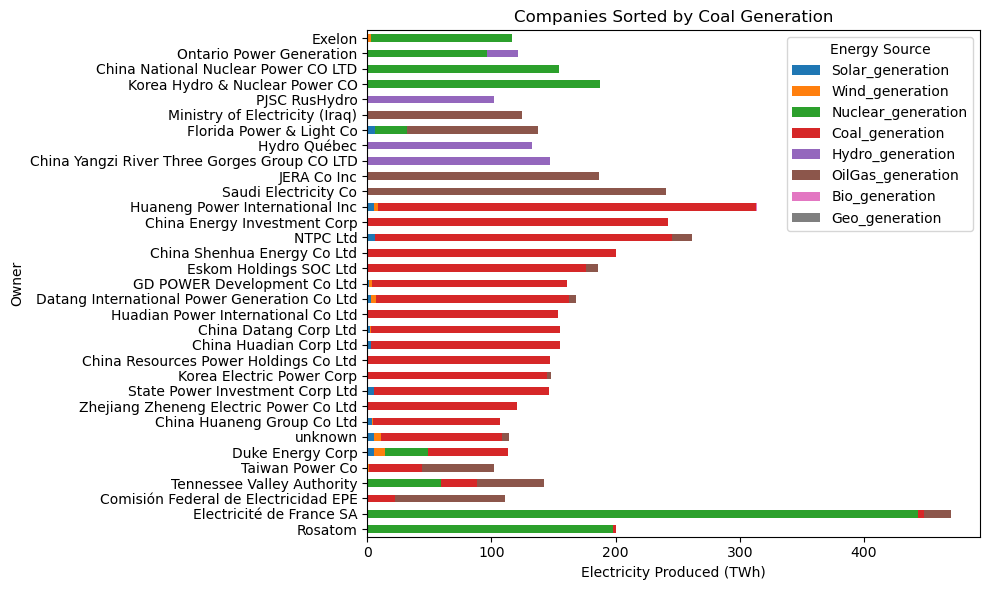

In [36]:
import matplotlib.pyplot as plt

# the columns you want to stack
plot_cols = [
    "Solar_generation",
    "Wind_generation",
    "Nuclear_generation",
    "Coal_generation",
    "Hydro_generation",
    "OilGas_generation",
    "Bio_generation",
    "Geo_generation",
]

# grab only your data rows
df_plot = df_merged_sorted.iloc[1:].copy()

# -----------------------------------------------------------------------------
# 1) SORT BY TOTAL PRODUCTION
# -----------------------------------------------------------------------------
# compute a helper “Total” column
df_plot["Total"] = df_plot[plot_cols].sum(axis=1)

# sort by that total
df_total = df_plot.sort_values("Total")

# now plot (pandas will ignore “Total” if you only pass y=plot_cols)
ax = df_total.plot(
    kind="barh",
    x="Owner",
    y=plot_cols,
    stacked=True,
    figsize=(10, 6),
)
ax.set_xlabel("Electricity Produced (TWh)")
ax.set_title("Companies Sorted by Total Production")
ax.legend(title="Energy Source", loc="upper right")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 2) SORT BY A SPECIFIC PRODUCTION METHOD
# -----------------------------------------------------------------------------
# pick whichever column you like—e.g. Solar_generation
method = "Coal_generation"

# sort by that one column
df_method = df_plot.sort_values(method)

ax = df_method.plot(
    kind="barh",
    x="Owner",
    y=plot_cols,
    stacked=True,
    figsize=(10, 6),
)
ax.set_xlabel("Electricity Produced (TWh)")
ax.set_title(f"Companies Sorted by {method.replace('_',' ').title()}")
ax.legend(title="Energy Source", loc="upper right")
plt.tight_layout()
plt.show()


In [28]:
df_merged_sorted


,Owner,Solar_capacity,Wind_capacity,Nuclear_capacity,Coal_capacity,Hydro_capacity,OilGas_capacity,Bio_capacity,Geo_capacity,total_capacity,Solar_generation,Wind_generation,Nuclear_generation,Coal_generation,Hydro_generation,OilGas_generation,Bio_generation,Geo_generation,total_estimated_generation
12923,Unknown,253479.200000,233793.200000,5.0,500.000000,39586.0727,4194.600,11598.0,537.0,543693.072700,399.686003,593.928245,0.034602,2.014800,145.645079,16.535113,57.911134,3.292884,1219.047859
6002,Huaneng Power International Inc,3570.000000,1298.000000,NaN,75511.770000,NaN,NaN,60.0,NaN,80439.770000,5.629176,3.297439,NaN,304.282228,NaN,NaN,0.299592,NaN,313.508436
3574,Electricité de France SA,NaN,NaN,64040.0,1260.000000,NaN,5477.700,NaN,NaN,70777.700000,NaN,NaN,443.182416,5.077296,NaN,21.593093,NaN,NaN,469.852805
8386,NTPC Ltd,3782.000000,50.000000,NaN,59395.000000,NaN,4007.000,NaN,NaN,67234.000000,5.963458,0.127020,NaN,239.338092,NaN,15.795594,NaN,NaN,261.224164
10447,Saudi Electricity Co,53.333333,NaN,NaN,NaN,NaN,60986.500,NaN,NaN,61039.833333,0.084096,NaN,NaN,NaN,NaN,240.408783,NaN,NaN,240.492879
2066,China Energy Investment Corp,NaN,NaN,NaN,60115.940000,NaN,NaN,NaN,NaN,60115.940000,NaN,NaN,NaN,242.243192,NaN,NaN,NaN,NaN,242.243192
2365,China Shenhua Energy Co Ltd,225.000000,NaN,NaN,49675.635000,NaN,NaN,NaN,NaN,49900.635000,0.354780,NaN,NaN,200.172939,NaN,NaN,NaN,NaN,200.527719
6672,JERA Co Inc,NaN,331.033333,NaN,NaN,NaN,47098.200,NaN,NaN,47429.233333,NaN,0.840957,NaN,NaN,NaN,185.661104,NaN,NaN,186.502061
3992,Eskom Holdings SOC Ltd,NaN,100.000000,NaN,43731.800000,NaN,2418.000,NaN,NaN,46249.800000,NaN,0.254040,NaN,176.221661,NaN,9.531756,NaN,NaN,186.007457
3013,Datang International Power Generation Co Ltd,1914.566667,1486.500000,NaN,38631.140000,NaN,1500.000,NaN,NaN,43532.206667,3.018889,3.776305,NaN,155.668042,NaN,5.913000,NaN,NaN,168.376235


In [1]:
capacity_sums = df_merged_sorted[capacity_cols].sum()

axx = capacity_sums.plot(kind="bar", figsize=(8, 5))

axx.set_title("Total Capacity by Technology")
axx.set_xlabel("Technology")
axx.set_ylabel("Capacity (MW)")  # or whatever unit your data is in

plt.tight_layout()
plt.savefig('totalcap.png',dpi=300)

NameError: name 'df_merged_sorted' is not defined